<a href="https://colab.research.google.com/github/bray2020/AI-works/blob/main/TL_with_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with Image Augmentation
- We will learn 
  - how the softmax layers are stacked on top of the pre-trained neural networks
  - How  a part of this network is used as a feature extracter and the newly affixed softmax layers as classifiers

- For doing so, we will learn an alternative method to read images inside a system.
  - Refer the file "DataGeneration_Augmentation.ipynb"


***In this case study, we will be using the pre-trained model known as InceptionV3***


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dropout
import os
import glob
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Tensorflow/waffle_pancakes"

## Steps to be followed:
- Preprocessing of the images
- Creating image data generator object with some augmentation
- Storing the data into train and test directories


In [ ]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import image

def preprocess(x):
  X = np.expand_dims(x, axis=0)
  X = preprocess_input(X)
  return X[0]


data_gen = image.ImageDataGenerator(rotation_range = 40,
                                    vertical_flip=True, 
                                    horizontal_flip=True, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2,
                                    fill_mode = 'nearest',
                                    preprocessing_function=preprocess)

train_generator = data_gen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=(150,150))
valid_generator = data_gen.flow_from_directory(os.path.join(base_dir, 'test'), target_size=(150,150))

Found 741 images belonging to 2 classes.
Found 389 images belonging to 2 classes.


##Create architecture:


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout

### Create a Base Model
- Create a base model by excluding top layers
- use pooling for last convolutional layer
- Observe the model summay - it will have only convolutional layers, but not any dense layers.
- It is a very huge model with several layers, though


In [ ]:
m = InceptionV3()
m.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3), pooling='avg')
#weights='imagenet' : 
#include_top=False  : Not keeping the top layer of Inception 

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

- Take output of the base model as x
- create  dense laeyr on top with relu activation
- as it is a binary problem, used 2 nodes in the output layer with softmax activation function

In [ ]:
x = base_model.output

#add a fully connected layer
x = Dense(1024, activation='relu')(x)

#softmax for predictions
predictions = Dense(2, activation='softmax')(x)

#this is the model we will train
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [ ]:
## freeze base layer:
for layer in base_model.layers:
  layer.trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
batch_size = 32

In [ ]:
history = model.fit_generator(train_generator,
    epochs=10, verbose=1, validation_data = valid_generator, shuffle=False,
    steps_per_epoch = 741//batch_size, validation_steps=389//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
23/23 [==============================] - 101s 3s/step - loss: 9.2618 - accuracy: 0.7324 - val_loss: 1.4455 - val_accuracy: 0.7786
Epoch 2/10
23/23 [==============================] - 51s 2s/step - loss: 2.4919 - accuracy: 0.7335 - val_loss: 0.5305 - val_accuracy: 0.8411
Epoch 3/10
23/23 [==============================] - 51s 2s/step - loss: 1.3479 - accuracy: 0.8221 - val_loss: 1.4924 - val_accuracy: 0.7292
Epoch 4/10
23/23 [==============================] - 51s 2s/step - loss: 1.0503 - accuracy: 0.8138 - val_loss: 2.7281 - val_accuracy: 0.6615
Epoch 5/10
23/23 [==============================] - 51s 2s/step - loss: 1.0208 - accuracy: 0.8275 - val_loss: 0.4785 - val_accuracy: 0.8411
Epoch 6/10
23/23 [==============================] - 51s 2s/step - loss: 0.5229 - accuracy: 0.8621 - val_loss: 1.4537 - val_accuracy: 0.7083
Epoch 7/10
23/23 [==============================] - 52s 2s/step - loss: 0.4871 - accuracy: 0.8685 - val_loss: 0.5899 - val_accuracy: 0.8099
Epoch 8/10
23/23 [=

In [ ]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,5.446946,0.771739,1.445509,0.778646,0
1,1.356967,0.820874,0.530537,0.841146,1
2,0.926178,0.854725,1.492362,0.729167,2
3,0.871490,0.827927,2.728144,0.661458,3
4,0.813948,0.861777,0.478495,0.841146,4
5,0.577428,0.856135,1.453721,0.708333,5
6,0.502161,0.860367,0.589930,0.809896,6
7,0.423951,0.866008,0.319879,0.875000,7
8,0.422872,0.866008,0.286988,0.893229,8
9,0.394717,0.875882,0.644961,0.783854,9


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

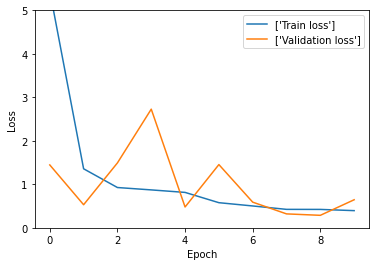

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label=['Train loss'])
  plt.plot(hist['epoch'], hist['val_loss'], label=['Validation loss'])
  plt.ylim([0,5])
  plt.legend()
  plt.show()

plot_history(history)

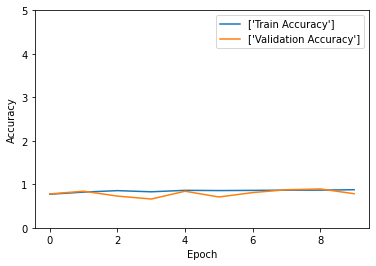

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'], label=['Train Accuracy'])
  plt.plot(hist['epoch'], hist['val_accuracy'], label=['Validation Accuracy'])
  plt.ylim([0,5])
  plt.legend()
  plt.show()

plot_history(history)

- So, it seems that after 8 epochs the validation loss has started increasing and the accuracy is decreasing. So there is a slight overfitting issue.
- Will apply some regularization technique to prevent the overfitting issue. 
- Applied dropout layer

In [ ]:
x2 = base_model.output

#add a fully connected layer
x2 = Dense(1024, activation='relu')(x2)
#used 20% Dropout here
Dropout(0.2),  

#softmax for predictions
predictions = Dense(2, activation='softmax')(x2)

#this is the model we will train
model2 = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
# freeze base layer:
for layer in base_model.layers:
  layer.trainable = False

# compile the 2nd model
model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# fit the model
history2 = model2.fit_generator(train_generator,
    epochs=10, verbose=1, validation_data = valid_generator, shuffle=False,
    steps_per_epoch = 741//batch_size, validation_steps=389//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
23/23 [==============================] - 78s 3s/step - loss: 12.5639 - accuracy: 0.6694 - val_loss: 0.7776 - val_accuracy: 0.7656
Epoch 2/10
23/23 [==============================] - 51s 2s/step - loss: 1.2767 - accuracy: 0.7953 - val_loss: 0.4910 - val_accuracy: 0.8568
Epoch 3/10
23/23 [==============================] - 51s 2s/step - loss: 0.5735 - accuracy: 0.8791 - val_loss: 0.7411 - val_accuracy: 0.7865
Epoch 4/10
23/23 [==============================] - 51s 2s/step - loss: 0.6287 - accuracy: 0.8456 - val_loss: 0.4867 - val_accuracy: 0.8516
Epoch 5/10
23/23 [==============================] - 52s 2s/step - loss: 0.9436 - accuracy: 0.8475 - val_loss: 1.9583 - val_accuracy: 0.6875
Epoch 6/10
23/23 [==============================] - 51s 2s/step - loss: 0.5322 - accuracy: 0.8810 - val_loss: 0.4906 - val_accuracy: 0.8516
Epoch 7/10
23/23 [==============================] - 51s 2s/step - loss: 0.4357 - accuracy: 0.8633 - val_loss: 0.8169 - val_accuracy: 0.7865
Epoch 8/10
23/23 [=

In [ ]:
import pandas as pd
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.469173,0.877292,0.490623,0.851562,5
6,0.464288,0.867419,0.816881,0.786458,6
7,0.437167,0.868829,0.331850,0.875000,7
8,0.277612,0.902680,0.637873,0.750000,8
9,0.352807,0.867419,0.283600,0.885417,9


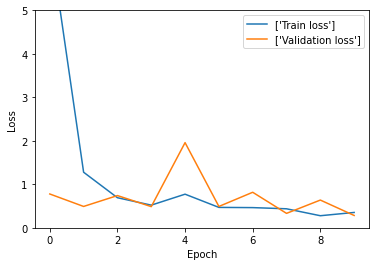

In [ ]:
def plot_history(history):
  hist2 = pd.DataFrame(history2.history)
  hist2['epoch'] = history2.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist2['epoch'], hist2['loss'], label=['Train loss'])
  plt.plot(hist2['epoch'], hist2['val_loss'], label=['Validation loss'])
  plt.ylim([0,5])
  plt.legend()
  plt.show()

plot_history(history2)

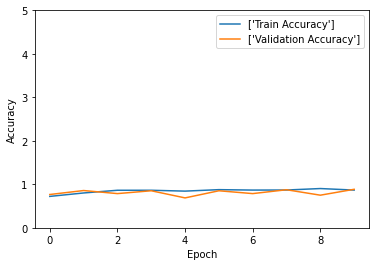

In [ ]:
def plot_history(history):
  hist2 = pd.DataFrame(history2.history)
  hist2['epoch'] = history2.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist2['epoch'], hist2['accuracy'], label=['Train Accuracy'])
  plt.plot(hist2['epoch'], hist2['val_accuracy'], label=['Validation Accuracy'])
  plt.ylim([0,5])
  plt.legend()
  plt.show()

plot_history(history2)

- Train and validation accuracy is almost overlapping, hence no overfitting by the model

### Make predictions:

In [ ]:
# sample image to test
img_waffle = image.load_img('/content/drive/MyDrive/Colab Notebooks/Tensorflow/waffle_pancakes/test/waffles/images_q=tbn_ANd9GcQMaP81CVen0O6_jXL6hond3aGqyV15LYXUF7okHeDV2TysbS1LvQ.png', target_size = (150, 150))
img_pancake = image.load_img('/content/drive/MyDrive/Colab Notebooks/Tensorflow/waffle_pancakes/test/pancakes/images_q=tbn_ANd9GcQ1Jtg2V7Me2uybx1rqxDMV58Ow17JamorQ3GCrW5TUyT1tcr8EMg.png', target_size = (150, 150))

In [ ]:
def model_predict(img, actual):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x_processed = preprocess_input(x)
    result = model2.predict(x_processed)
    if(result[0][0]<.50):
        result="Waffle"
    else:
        result="Pancake"
        
    plt.figure()
    plt.imshow(img)
    plt.title('Actual : {} --> Predicted  : {}'.format(actual, result))

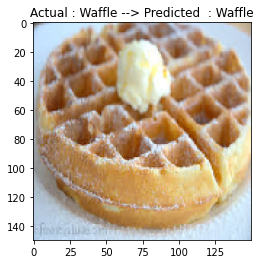

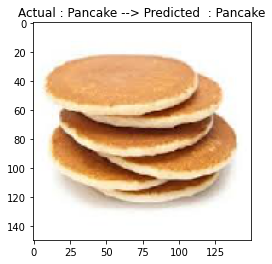

In [ ]:
pred_waffle = model_predict(img_waffle, "Waffle")
pred_pancake = model_predict(img_pancake, "Pancake")

In [ ]:
## Confusion matrix and classification report:
x = image.img_to_array(valid_generator)
x = np.expand_dims(x, axis = 0)
x_processed = preprocess_input(x)
preds = model2.predict(x_processed)